In [2]:
!pip install torch-lr-finder

In [3]:
!pip install split-folders

In [1]:
import os
import pandas as pd
import random
import seaborn as sns
import cv2
import torch
import torchvision
import shutil

from PIL import Image
from torch.utils.data import WeightedRandomSampler
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam

import torchvision.models as models
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import splitfolders
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# I. Data Preparation Phase

In [2]:
def pad_image(image):
    width, height = image.size
    max_dim = max(width, height)

    
    background_color = tuple(np.random.randint(0, 256, size=3))
    background = Image.new('RGB', (max_dim, max_dim), background_color)

    pos = ((max_dim - width) // 2, (max_dim - height) // 2)
    background.paste(image, pos)

    return background

In [3]:
def sobel_edge_detection(image):
    image = np.array(image)
    channels = []
    for i in range(3):  
        gray = image[:, :, i]
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel = np.uint8(sobel)
        channels.append(sobel)
    sobel = np.stack(channels, axis=-1) 
    return Image.fromarray(sobel)

class SobelEdgeDetection(object):
    def __call__(self, img):
        return sobel_edge_detection(img)

In [4]:
data_transforms = transforms.Compose([
    transforms.Lambda(pad_image), 
    transforms.Resize(size=(512, 512)),
    transforms.CenterCrop(448),
    SobelEdgeDetection(),    
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
class CoffeeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        class_labels = sorted(os.listdir(root_dir))
        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    label_vector = [0] * len(class_labels)
                    label_vector[label_idx] = 1
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)

In [6]:
def visualize_images_before_after(dataset, transform, class_labels, num_images=10):
    num_rows = (num_images + 1) // 2  
    fig, ax = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    
    for i in range(num_images):
        row = i // 2
        col = (i % 2) * 2

        sample_index = random.randint(0, len(dataset) - 1)

        img_path = dataset.image_paths[sample_index]
        label_vector = dataset.labels[sample_index]
        label_idx = label_vector.index(1)  
        label_name = class_labels[label_idx]  

        img = Image.open(img_path).convert('RGB')
        ax[row, col].imshow(img)
        ax[row, col].title.set_text(f"Original Image - {label_name}")

        img_transformed = transform(img)
        img_transformed = img_transformed.permute(1, 2, 0).numpy()
        img_transformed = (img_transformed * 0.229) + 0.485  
        ax[row, col + 1].imshow(img_transformed)
        ax[row, col + 1].title.set_text(f"Processed Image - {label_name}")

    plt.tight_layout()
    plt.show()


In [7]:
data_dir = 'E:/Jupyter/Samples/SSamples'
dataset = CoffeeDataset(data_dir, transform=data_transforms)
class_labels = sorted(os.listdir(data_dir))
labels_for_viz = {i: class_labels[i] for i in range(len(class_labels))}


In [8]:
dataset = CoffeeDataset(data_dir, transform=data_transforms)
class_labels = sorted(os.listdir(data_dir))
print("Class labels:", class_labels)

Class labels: ['Excessive Sunlight', 'Leaf Rust', 'Lichens', 'No Disease', 'Sooty Mold', 'Wilt']


In [9]:
def split_dataset(root_dir, output_dir, test_ratio=(10, 20)):
    class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_dir in class_dirs:
        class_path = os.path.join(root_dir, class_dir)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(images)

        if len(images) < 100:
            num_test = test_ratio[0]
        else:
            num_test = test_ratio[1]

        test_images = images[:num_test]
        remaining_images = images[num_test:]

        os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_dir, img))

        # Use splitfolders to split remaining images into train/val sets
        remaining_dir = os.path.join(output_dir, 'remaining', class_dir)
        os.makedirs(remaining_dir, exist_ok=True)
        for img in remaining_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(remaining_dir, img))

    splitfolders.ratio(os.path.join(output_dir, 'remaining'), output=output_dir, seed=42, ratio=(.75, .25))

    # Cleanup
    shutil.rmtree(os.path.join(output_dir, 'remaining'))

In [10]:
output_dir = 'splitted_dataS'
split_dataset(data_dir, output_dir)

Copying files: 1030 files [00:06, 153.67 files/s]


In [10]:
train = datasets.ImageFolder(root="/Jupyter/ML/splitted_dataS/train",
                              transform=data_transforms)

val = datasets.ImageFolder(root="/Jupyter/ML/splitted_dataS/val",
                              transform=data_transforms)

test = datasets.ImageFolder(root="/Jupyter/ML/splitted_dataS/test",
                              transform=data_transforms)

data = datasets.ImageFolder(root="E:\Jupyter\Samples\SSamples",
                              transform=data_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

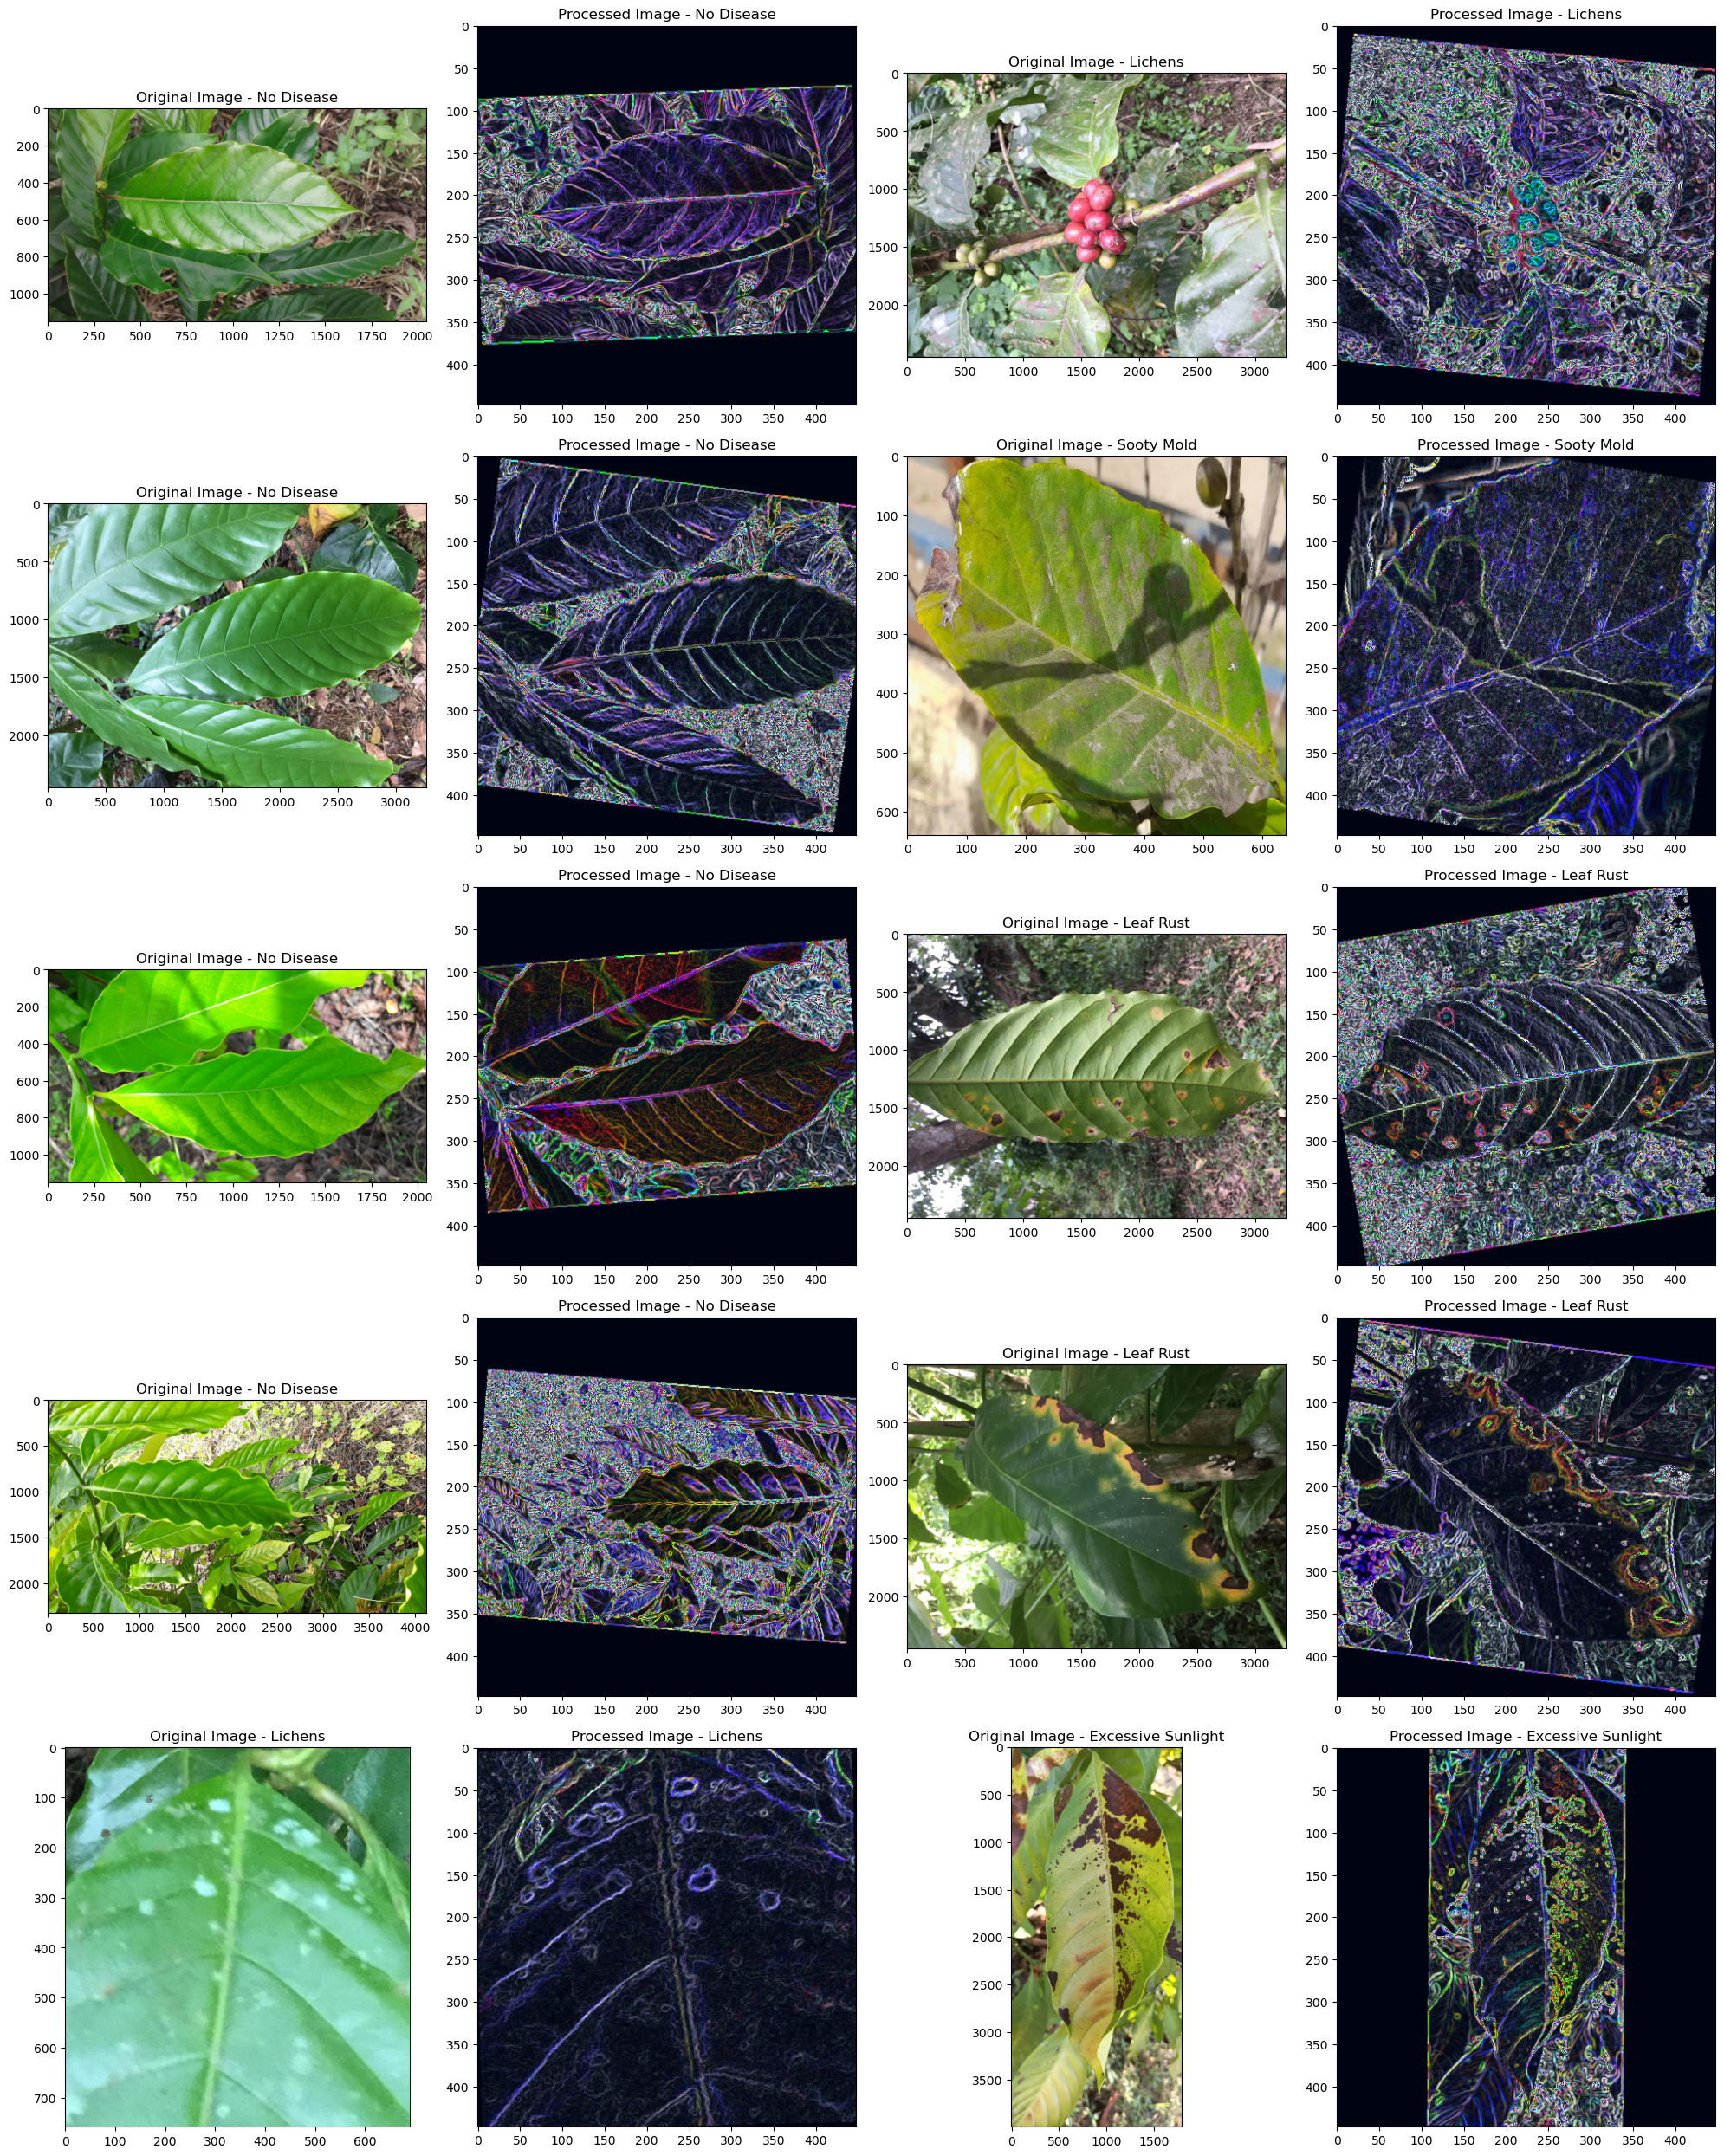

In [11]:
visualize_images_before_after(dataset, data_transforms, class_labels, num_images=10)

In [12]:
class_to_idx = {label: idx for idx, label in enumerate(class_labels)}
idx_to_class = {idx: label for label, idx in class_to_idx.items()}

print("Dataset Labels:\n", class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series([class_to_idx[dataset.classes[target]] for target in dataset.targets]).value_counts()
    print(f"Images per Class in {name}:")
    for idx in sorted(images_per_class.index):
        print(f"{idx}    {idx_to_class[idx]}: {images_per_class[idx]}")
    print()

Dataset Labels:
 {'Excessive Sunlight': 0, 'Leaf Rust': 1, 'Lichens': 2, 'No Disease': 3, 'Sooty Mold': 4, 'Wilt': 5} 

Images per Class in TRAIN:
0    Excessive Sunlight: 43
1    Leaf Rust: 354
2    Lichens: 63
3    No Disease: 146
4    Sooty Mold: 141
5    Wilt: 33

Images per Class in VALIDATION:
0    Excessive Sunlight: 11
1    Leaf Rust: 119
2    Lichens: 22
3    No Disease: 49
4    Sooty Mold: 48
5    Wilt: 11

Images per Class in TEST:
0    Excessive Sunlight: 10
1    Leaf Rust: 20
2    Lichens: 10
3    No Disease: 20
4    Sooty Mold: 20
5    Wilt: 10



In [13]:
class_counts = np.bincount([label for _, label in train.samples])
class_weights = 1. / class_counts
samples_weights = [class_weights[label] for _, label in train.samples]
samples_weights = torch.tensor(samples_weights)
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)
train_loader = DataLoader(dataset=train, batch_size=32, sampler=sampler, num_workers=0, pin_memory=True)

In [14]:
train_loader = DataLoader(dataset=train,
                             batch_size=32,
                             sampler=sampler,
                             num_workers=0,
                             pin_memory=True)

val_loader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=0,
                             shuffle=True,
                             pin_memory=True)

test_loader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=0,
                             shuffle=False,
                             pin_memory=True)

In [15]:
print("Length of training dataset:", len(train))
print("Length of validation dataset:", len(val))
print("Length of test dataset:", len(test))

Length of training dataset: 780
Length of validation dataset: 260
Length of test dataset: 90


# II. Model Setup Phase

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=models.ResNet50_Weights.DEFAULT)

for param in resnet.parameters():
    param.requires_grad = False

Using cache found in C:\Users\Nicko/.cache\torch\hub\pytorch_vision_v0.10.0


In [18]:
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels) 
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [19]:
# Move the model to the GPU
model = resnet.to(device)

# III. Loss Function and Optimizer Setup

In [20]:
total_samples = len(train)
samples_per_class = [len(os.listdir(os.path.join(data_dir, label))) for label in class_labels]

print("Samples per class:", samples_per_class)

initial_class_weights = [total_samples / samples_per_class[i] for i in range(len(class_labels))]

class_weights = [np.log1p(weight) for weight in initial_class_weights]

print("Initial class weights:", initial_class_weights)
print("Log-scaled class weights:", class_weights)


weights = torch.tensor(class_weights).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)


Samples per class: [54, 493, 95, 215, 209, 54]
Initial class weights: [14.444444444444445, 1.5821501014198782, 8.210526315789474, 3.627906976744186, 3.7320574162679425, 14.444444444444445]
Log-scaled class weights: [2.7372493557944724, 0.9486224245147163, 2.2203469947570738, 1.5321047090309299, 1.554360079657901, 2.7372493557944724]


In [21]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

E:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


# IV. Training Phase

In [22]:
def train_model(model, criterion, optimizer, num_epochs=64, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    early_stopping_counter = 0
    best_loss = float('inf')
    early_stop = False  

    for epoch in range(num_epochs):
        if early_stop:  
            print('Breaking out of epoch loop due to early stopping.')
            break  

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {lr}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.cuda()
                labels = labels.cuda().long()

                labels = torch.nn.functional.one_hot(labels, num_classes=6).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                preds = outputs > 0.5
                corrects = (preds == labels).sum().item()
                running_corrects += corrects
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / (len(data_loader.dataset) * num_classes)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            if phase == 'val':
                scheduler.step(epoch_loss)  
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
                    if early_stopping_counter >= patience:
                        model.load_state_dict(best_model_wts)
                        print(f'Early stopping triggered.')
                        early_stop = True  
                        break  

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, time_elapsed, best_loss, best_acc

model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc = train_model(model, criterion, optimizer, num_epochs=64, patience=5)

torch.save(model.state_dict(), 'model.pth')

print("Training finished...\n")


Epoch 1/64
----------
Learning Rate: 0.001
train Loss: 0.6408 Acc: 0.8368
val Loss: 0.5692 Acc: 0.8346
Epoch 2/64
----------
Learning Rate: 0.001
train Loss: 0.5290 Acc: 0.8472
val Loss: 0.4991 Acc: 0.8372
Epoch 3/64
----------
Learning Rate: 0.001
train Loss: 0.4550 Acc: 0.8613
val Loss: 0.4454 Acc: 0.8590
Epoch 4/64
----------
Learning Rate: 0.001
train Loss: 0.4210 Acc: 0.8806
val Loss: 0.4346 Acc: 0.8635
Epoch 5/64
----------
Learning Rate: 0.001
train Loss: 0.3964 Acc: 0.8895
val Loss: 0.4142 Acc: 0.8744
Epoch 6/64
----------
Learning Rate: 0.001
train Loss: 0.3544 Acc: 0.9024
val Loss: 0.3865 Acc: 0.8737
Epoch 7/64
----------
Learning Rate: 0.001
train Loss: 0.3283 Acc: 0.9075
val Loss: 0.3487 Acc: 0.8840
Epoch 8/64
----------
Learning Rate: 0.001
train Loss: 0.3240 Acc: 0.9073
val Loss: 0.3582 Acc: 0.8808
Early stopping counter: 1 out of 5
Epoch 9/64
----------
Learning Rate: 0.001
train Loss: 0.3067 Acc: 0.9175
val Loss: 0.3318 Acc: 0.8865
Epoch 10/64
----------
Learning Rate: 

# V. Evaluation and Inference Phase

In [23]:
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report

def test_model(model, test_loader, device, class_labels):
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    # Convert predictions and labels to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Individual models
    models = [
        ('svm', SVC()),
        ('knn', KNeighborsClassifier()),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
    ]

    for name, model in models:
        model.fit(all_predictions.reshape(-1, 1), all_labels)
        preds = model.predict(all_predictions.reshape(-1, 1))
        print(f"{name.upper()} Classification Report:")
        print(classification_report(all_labels, preds, target_names=class_labels, zero_division=1))

    # Voting Classifier
    voting_model = VotingClassifier(estimators=models, voting='hard')
    voting_model.fit(all_predictions.reshape(-1, 1), all_labels)
    voting_preds = voting_model.predict(all_predictions.reshape(-1, 1))
    print("Voting Classifier Classification Report:")
    print(classification_report(all_labels, voting_preds, target_names=class_labels, zero_division=1))

# Call the function to test the models
test_model(model, test_loader, device, class_labels)


SVM Classification Report:
                    precision    recall  f1-score   support

Excessive Sunlight       0.83      1.00      0.91        10
         Leaf Rust       0.94      0.85      0.89        20
           Lichens       0.70      0.70      0.70        10
        No Disease       1.00      0.95      0.97        20
        Sooty Mold       0.85      0.85      0.85        20
              Wilt       0.91      1.00      0.95        10

          accuracy                           0.89        90
         macro avg       0.87      0.89      0.88        90
      weighted avg       0.89      0.89      0.89        90

KNN Classification Report:
                    precision    recall  f1-score   support

Excessive Sunlight       0.83      1.00      0.91        10
         Leaf Rust       0.94      0.85      0.89        20
           Lichens       1.00      0.00      0.00        10
        No Disease       1.00      0.95      0.97        20
        Sooty Mold       0.67      1.00   

In [24]:
def test_model():
    model = models.resnet50(weights = None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 6)

    model = model.to(device)
    model.load_state_dict(torch.load("model.pth"))
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    print("Test Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_labels))

    # Return a flattened array of all predictions
    return np.array(all_predictions).flatten()

# Call the function to test the model
all_preds = test_model()


Test Classification Report:
                    precision    recall  f1-score   support

Excessive Sunlight       0.83      1.00      0.91        10
         Leaf Rust       1.00      0.75      0.86        20
           Lichens       0.80      0.80      0.80        10
        No Disease       0.95      0.95      0.95        20
        Sooty Mold       0.77      0.85      0.81        20
              Wilt       0.91      1.00      0.95        10

          accuracy                           0.88        90
         macro avg       0.88      0.89      0.88        90
      weighted avg       0.89      0.88      0.88        90



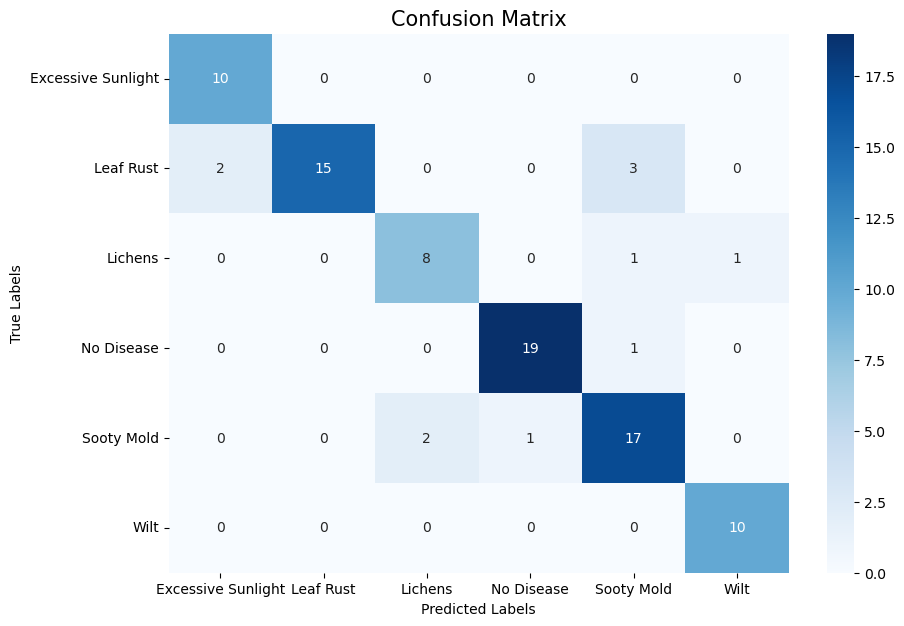

In [25]:
from sklearn.metrics import confusion_matrix

# Get the unique class labels
unique_labels = sorted(set(test.targets + list(range(len(class_labels)))))

# Create the confusion matrix
cm = confusion_matrix(test.targets, all_preds, labels=unique_labels)

# Plot the confusion matrix with appropriate labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix", size=15)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

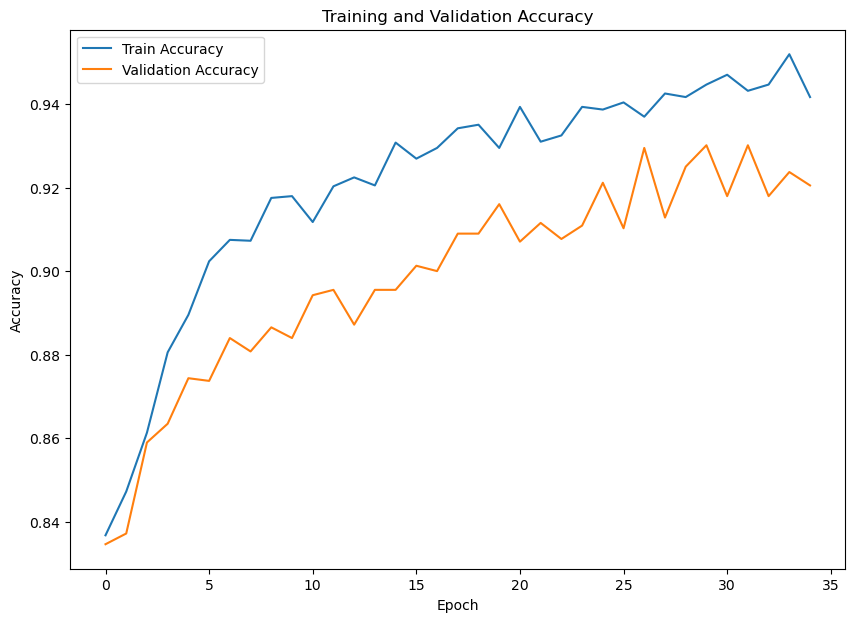

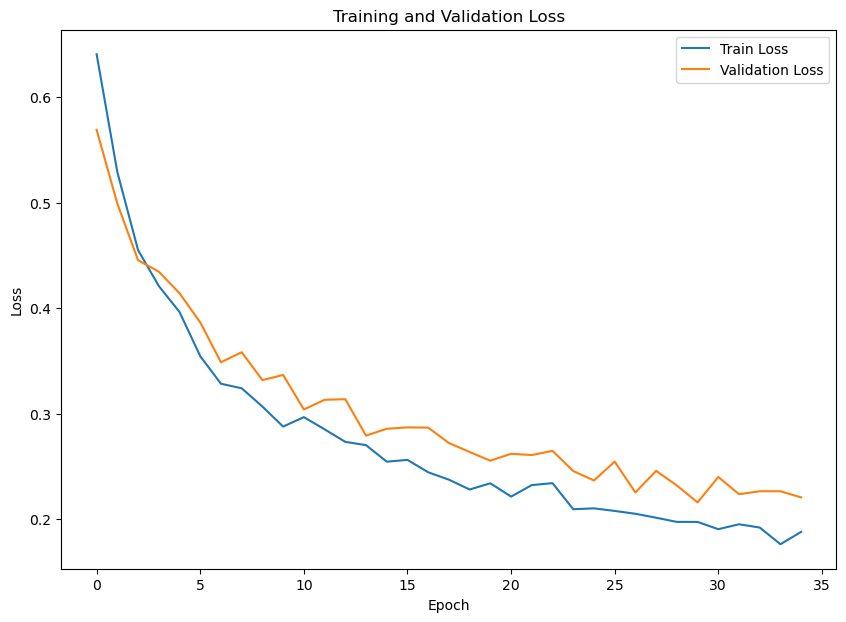

Best val Loss: 0.2158
Best val Acc: 0.9301


In [26]:
def plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc):
    # Plot accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print training time and best metrics
    print(f'Best val Loss: {best_loss:.4f}')
    print(f'Best val Acc: {best_acc:.4f}')

plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc)


In [63]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import numpy as np

data_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    SobelEdgeDetection(),  
    transforms.Lambda(pad_image), 
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_model(model_path, num_classes=6):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path))
    model = model.to("cuda")
    model.eval()
    return model

def image_predict(image_path, model, transform, class_labels, threshold=0.5):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to("cuda")

    with torch.no_grad():
        outputs = model(image)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()

        for i, prob in enumerate(probs):
            print(f"{class_labels[i]}: {prob:.4f}")

        confidence_levels = {class_labels[i]: float(probs[i]) for i in range(len(class_labels))}

        highest_prob = np.max(probs)
        highest_class = class_labels[np.argmax(probs)]
        if highest_prob < threshold:
            return f"Uncertain: {highest_class} with confidence {highest_prob:.2f}", confidence_levels

        predicted_labels = [class_labels[i] for i in range(len(class_labels)) if probs[i] > threshold]
        return predicted_labels, confidence_levels


model_path = 'model.pth'  
model = load_model(model_path)

image_path = 'E:\Jupyter\ML\ValidationSamples\lichens3.jpg'  
predictions, confidences = image_predict(image_path, model, data_transforms, class_labels)

print("Predicted classes:", predictions)
print("Confidence levels:", confidences)


Excessive Sunlight: 0.0063
Leaf Rust: 0.1987
Lichens: 0.5457
No Disease: 0.0090
Sooty Mold: 0.4758
Wilt: 0.1135
Predicted classes: ['Lichens']
Confidence levels: {'Excessive Sunlight': 0.006340330466628075, 'Leaf Rust': 0.1987183690071106, 'Lichens': 0.545687198638916, 'No Disease': 0.009017594158649445, 'Sooty Mold': 0.4758273661136627, 'Wilt': 0.11353528499603271}
